In [71]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from efficientnet import EfficientNetB0, center_crop_and_resize, preprocess_input

import time

import matplotlib.pyplot as plt

import cv2

In [9]:
BASEPATH = "data/stanford-dogs-dataset/Images/"

LABELS = set()

paths = []
    
for d in os.listdir(BASEPATH):
    LABELS.add(d)
    paths.append((BASEPATH+d, d))

In [78]:
# resizing and converting to RGB
def load_and_preprocess_image(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return x

In [79]:
X = []
y = []

for path, label in paths:
    for image_path in os.listdir(path):
        image = load_and_preprocess_image(path+"/"+image_path)
        
        X.append(image)
        y.append(label)

In [12]:
encoder = LabelBinarizer()

X = np.array(X)
y = encoder.fit_transform(np.array(y))

print(X[0].dtype)
print(y[0])

uint8
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


(20580, 224, 224, 3)
(20580, 120)


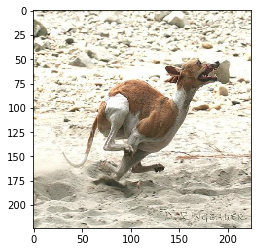

In [13]:
print(X.shape)
print(y.shape)
plt.imshow(X[1])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [95]:
from keras import models
from keras import layers
from keras import callbacks

In [100]:
conv_base=EfficientNetB0(weights='imagenet',include_top=False, input_shape=(224,224,3))

In [101]:
model = models.Sequential()
model.add(base_model)
model.add(layers.AveragePooling2D((5,5)))
model.add(layers.Flatten())
#model.add(layers.Dense(1024))
#model.add(layers.Dropout(0.5))
#model.add(layers.Dense(512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(LABELS),activation='softmax'))
 

# multiply_16
# set 'multiply_16' and following layers trainable
#conv_base.trainable = True

#set_trainable = False
#for layer in conv_base.layers:
#    if layer.name == 'multiply_16':
 #       set_trainable = True
  #  if set_trainable:
   #     layer.trainable = True
    #else:
     #   layer.trainable = False
    
    
model.compile("adam",loss="categorical_crossentropy",metrics=["accuracy"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
average_pooling2d_6 (Average (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 120)               153720    
Total params: 4,203,284
Trainable params: 4,161,268
Non-trainable params: 42,016
_________________________________________________________________
None


In [102]:
early_stopping = EarlyStopping(patience=10, verbose=1,restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.1, patience=3,verbose=1)

In [103]:
model.fit(X_train,y_train,batch_size=50,epochs=100,validation_data=(X_test,y_test), 
          callbacks=[early_stopping, reduce_lr])

Train on 16464 samples, validate on 4116 samples
Epoch 1/100
16464/16464 [==============================] - 296s 18ms/step - loss: 0.6181 - acc: 0.8661 - val_loss: 1.8188 - val_acc: 0.6365
Epoch 2/100
16464/16464 [==============================] - 202s 12ms/step - loss: 0.1598 - acc: 0.9538 - val_loss: 2.2396 - val_acc: 0.5882
Epoch 3/100
16464/16464 [==============================] - 202s 12ms/step - loss: 0.1698 - acc: 0.9507 - val_loss: 2.0453 - val_acc: 0.6241
Epoch 4/100
16464/16464 [==============================] - 202s 12ms/step - loss: 0.1363 - acc: 0.9611 - val_loss: 2.1602 - val_acc: 0.6042

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/100
16464/16464 [==============================] - 202s 12ms/step - loss: 0.0748 - acc: 0.9797 - val_loss: 1.6495 - val_acc: 0.6754
Epoch 6/100
16464/16464 [==============================] - 202s 12ms/step - loss: 0.0394 - acc: 0.9886 - val_loss: 1.6574 - val_acc: 0.6769
Epoch 7/100
16464/16464 [====

In [104]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print("loss on the test set is {:.2f}".format(loss))
print("accuracy on the test set is {:.3f}".format(acc))

loss on the test set is 1.65
accuracy on the test set is 0.683


In [105]:
predictions = model.predict(X_test)

In [106]:
label_predictions = encoder.inverse_transform(predictions)

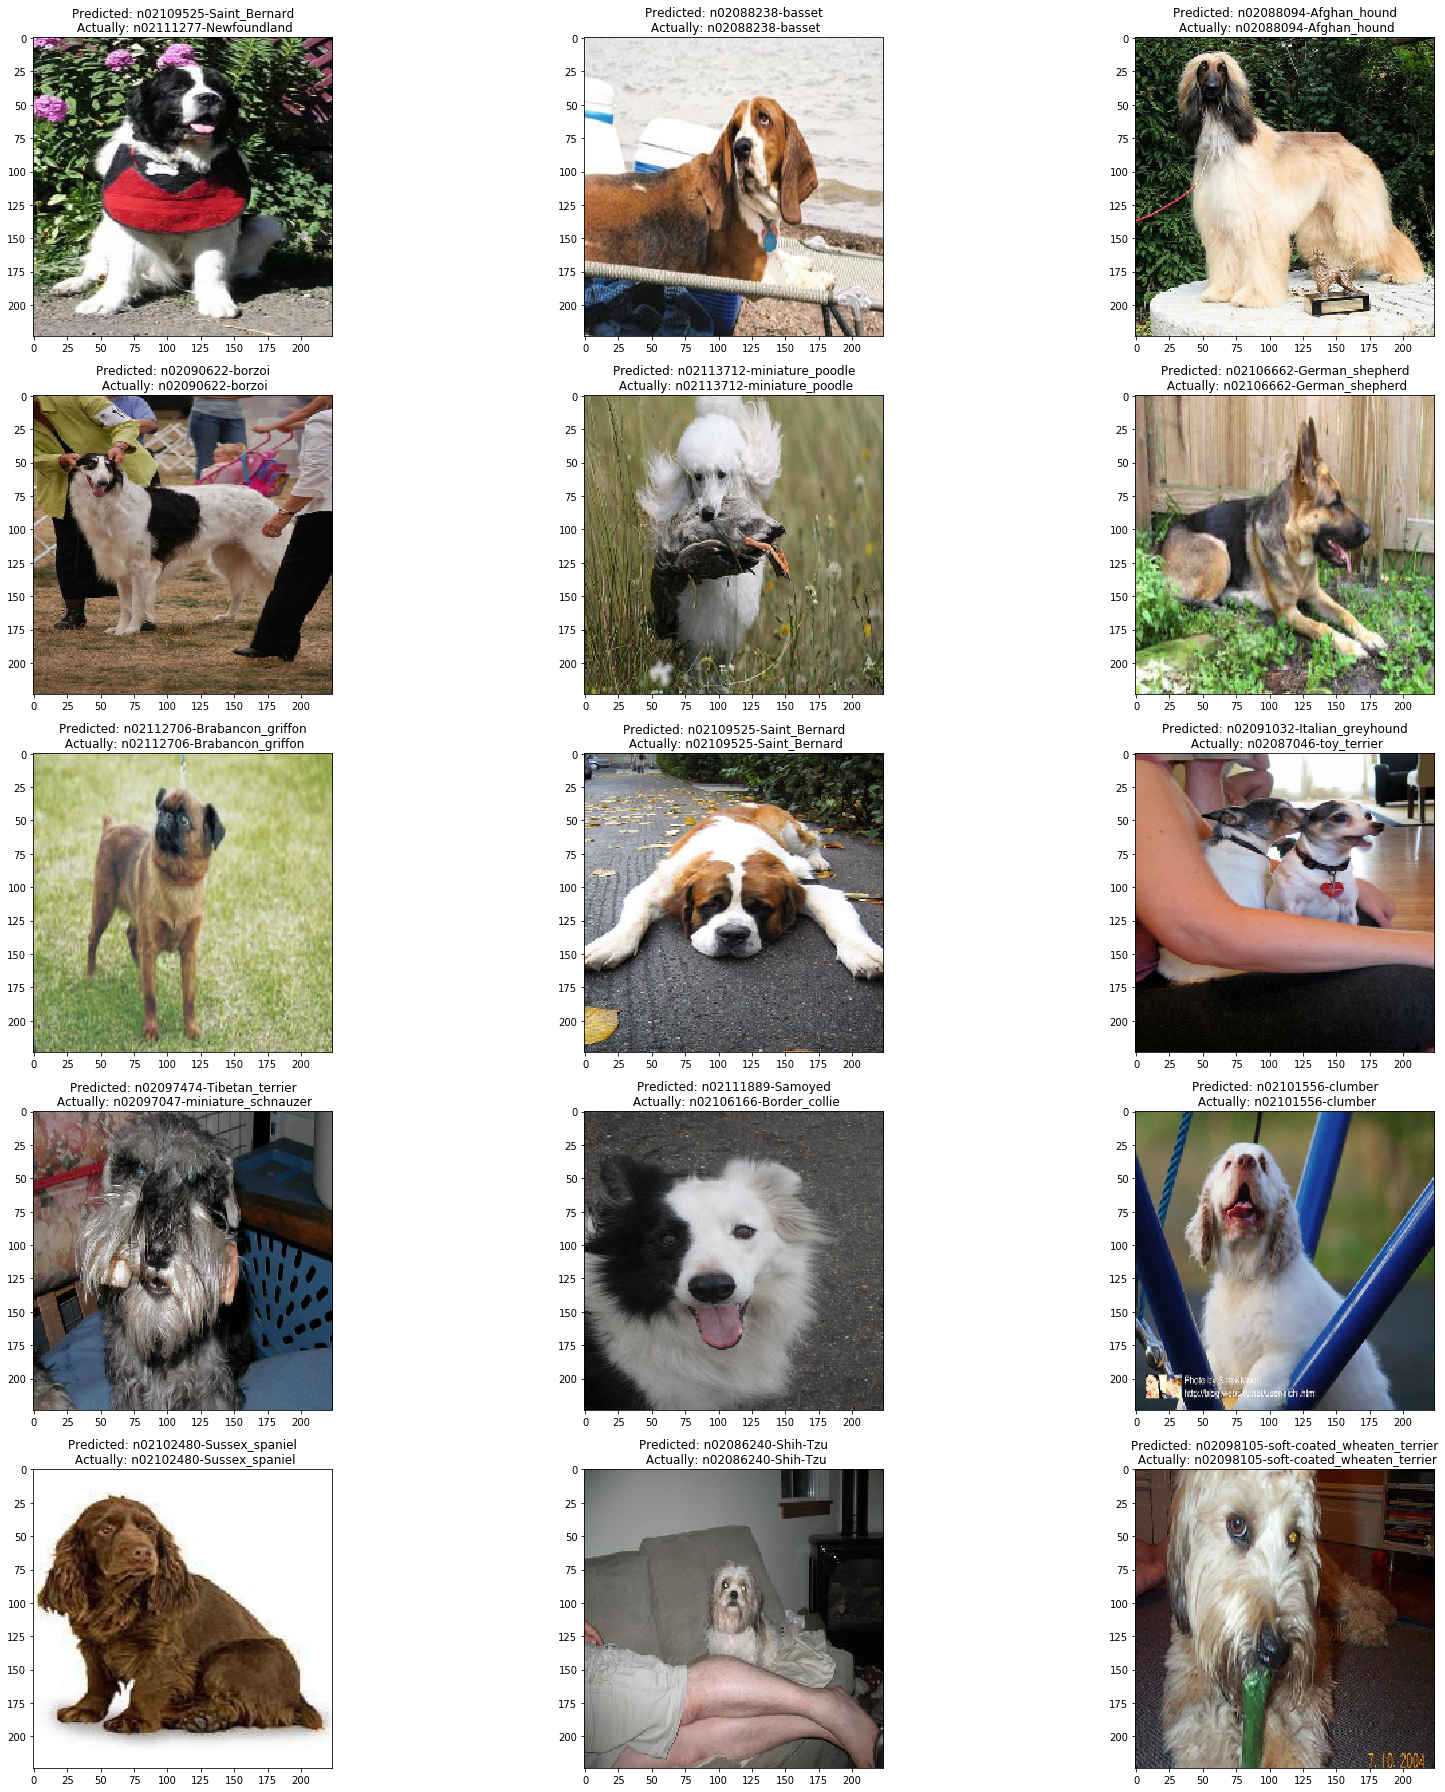

In [107]:
rows, cols = 5, 3
size = 25

fig,ax=plt.subplots(rows,cols)
fig.set_size_inches(size,size)
for i in range(rows):
    for j in range (cols):
        index = np.random.randint(0,len(X_test))
        ax[i,j].imshow(X_test[index])
        ax[i,j].set_title('Predicted: {}\n Actually: {}'
                          .format(label_predictions[index], encoder.inverse_transform(y_test)[index]))
        
plt.tight_layout()

In [55]:
model.save("efficientnetb0-model-{:.2f}acc-{:.2f}loss-{:.0f}.hdf5".format(acc, loss, time.time()))

# Using the ImageDataGenerator

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255.0,
                                   shear_range=0.2,
                                   rotation_range=20.,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=[0.9, 1.25],
                                   brightness_range=[0.5, 1.5],
                                   horizontal_flip=True
                                   validation_split=0.2)

In [6]:
batch_size = 64

train_generator = train_datagen.flow_from_directory(
    BASEPATH,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    BASEPATH, # same directory as training data
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 50, callbacks=[early_stopping, reduce_lr])

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
129/129 [==============================] - 261s 2s/step - loss: 4.6915 - acc: 0.0176 - val_loss: 4.4001 - val_acc: 0.0327
Epoch 2/50
129/129 [==============================] - 241s 2s/step - loss: 4.1060 - acc: 0.0612 - val_loss: 3.7582 - val_acc: 0.1083
Epoch 3/50
129/129 [==============================] - 240s 2s/step - loss: 3.6548 - acc: 0.1139 - val_loss: 3.5288 - val_acc: 0.1388
Epoch 4/50
129/129 [==============================] - 240s 2s/step - loss: 3.4107 - acc: 0.1549 - val_loss: 3.3535 - val_acc: 0.1677
Epoch 5/50
129/129 [==============================] - 240s 2s/step - loss: 3.2506 - acc: 0.1806 - val_loss: 3.2477 - val_acc: 0.1798
Epoch 6/50
129/129 [==============================] - 241s 2s/step - loss: 3.1220 - acc: 0.2034 - val_loss: 3.1261 - val_acc: 0.2041
Epoch 7/50
129/129 [==============================] - 241s 2s/ste

## Evaluation

In [13]:
loss, acc = model.evaluate_generator(validation_generator,verbose=0)

In [17]:
print(loss,acc)
#print(f"loss on the test set is {loss:.2f}")
#print(f"accuracy on the test set is {acc:.3f}")

2.6710992753505707 0.33202356


In [10]:
predictions = model.predict_generator(validation_generator)

NameError: name 'encoder' is not defined

In [11]:
predictions

array([[5.01862681e-03, 1.35878678e-02, 5.84158711e-02, ...,
        9.82252765e-04, 1.18811462e-04, 1.06243919e-04],
       [5.21790722e-10, 7.51390772e-08, 9.25380945e-08, ...,
        9.25014376e-09, 8.06528710e-09, 4.09361824e-08],
       [2.60171189e-04, 6.65850803e-06, 1.37960978e-06, ...,
        3.73664522e-03, 1.37669279e-03, 1.53307598e-02],
       ...,
       [1.48904242e-03, 1.53790802e-06, 1.27401407e-04, ...,
        3.17899801e-04, 4.10688262e-05, 1.14272634e-05],
       [3.23142018e-03, 1.13431895e-02, 4.24724212e-03, ...,
        6.37218310e-03, 2.59050122e-03, 5.45224117e-04],
       [4.26332826e-06, 3.28940805e-05, 7.34355068e-03, ...,
        2.78054067e-05, 8.99226052e-06, 9.83871686e-08]], dtype=float32)

In [ ]:
rows, cols = 5, 3
size = 25

fig,ax=plt.subplots(rows,cols)
fig.set_size_inches(size,size)
for i in range(rows):
    for j in range (cols):
        index = np.random.randint(0,len(X_test))
        ax[i,j].imshow(X_test[index])
        ax[i,j].set_title(f'Predicted: {label_predictions[index]}\n Actually: {encoder.inverse_transform(y_test)[index]}')
        
plt.tight_layout()

In [25]:
model.save('./generator_trained_model.hdf5')